# Example of gsa with sam2 (WIP)

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


# Automatic Mask Generation with sam2

First, we create a mask for the first frame of the video. This tells sam2 what to track. To create this intial mask, we will use sam2 automatic mask generator. 

In [3]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [ ]:
ADT_PROCESSED_DIR = "/home/jackd/source/egolifter/adt_processed_new"
SCENE_NAME = "Apartment_release_golden_skeleton_seq100_10s_sample"
base_video_dir = f"adt_0_input_video"
video_scene_dir = f"{base_video_dir}/{SCENE_NAME}"

In [13]:
# Rename files in the video scene directory to remove "rgb_" prefix
for filename in os.listdir(video_scene_dir):
    if filename.startswith("rgb_"):
        new_filename = filename[4:]  # Remove the "rgb_" prefix
        os.rename(os.path.join(video_scene_dir, filename), os.path.join(video_scene_dir, new_filename))
        print(f"Renamed {filename} to {new_filename}")

Renamed rgb_87559436156850.jpg to 87559436156850.jpg
Renamed rgb_87552737227137.jpg to 87552737227137.jpg
Renamed rgb_87559836101137.jpg to 87559836101137.jpg
Renamed rgb_87558269678675.jpg to 87558269678675.jpg
Renamed rgb_87557303194100.jpg to 87557303194100.jpg
Renamed rgb_87553003853225.jpg to 87553003853225.jpg
Renamed rgb_87555903395600.jpg to 87555903395600.jpg
Renamed rgb_87559102878550.jpg to 87559102878550.jpg
Renamed rgb_87556136690600.jpg to 87556136690600.jpg
Renamed rgb_87559569469887.jpg to 87559569469887.jpg
Renamed rgb_87559736110225.jpg to 87559736110225.jpg
Renamed rgb_87560969249675.jpg to 87560969249675.jpg
Renamed rgb_87559302847512.jpg to 87559302847512.jpg
Renamed rgb_87553870380100.jpg to 87553870380100.jpg
Renamed rgb_87554370311050.jpg to 87554370311050.jpg
Renamed rgb_87558636286725.jpg to 87558636286725.jpg
Renamed rgb_87552303964425.jpg to 87552303964425.jpg
Renamed rgb_87560536031725.jpg to 87560536031725.jpg
Renamed rgb_87557636452475.jpg to 875576364524

In [14]:
import numpy as np
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# define your model config and checkpoint paths
sam2_checkpoint = "./sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

# build the SAM2 model
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# create the automatic mask generator
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [19]:
# Get the first image from video_scene_dir
first_image_example = os.listdir(video_scene_dir)[0]
print(f"First image path: {first_image_example}")

First image path: 87558902910850.jpg


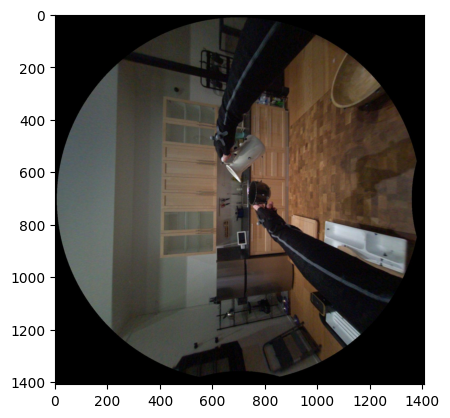

In [20]:
# Display the first frame image as an example
image_path = f"{video_scene_dir}/{first_image_example}"
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)
# Show the image
plt.imshow(image_np)


In [21]:
# generate initial masks for the first frame
masks = mask_generator.generate(image_np)

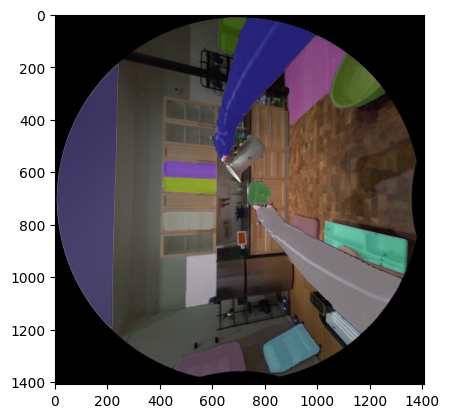

In [22]:
# Display the masks
plt.imshow(image)
show_anns(masks)
plt.show() 

In [26]:
# Save the mask to the output directory
video_name = SCENE_NAME # file structued used by vos script. we can clean this up later
init_masks_dir = f"adt_1_init_masks"
os.makedirs(os.path.join(init_masks_dir, video_name), exist_ok=True)

In [27]:
from utils.vos_inference import save_masks_to_dir, DAVIS_PALETTE

per_obj_output_mask = {
    idx: mask["segmentation"] for idx, mask in enumerate(masks)
}

save_masks_to_dir(
    init_masks_dir,
    video_name,
    first_image_example,
    per_obj_output_mask,
    height=image_np.shape[0],
    width=image_np.shape[1],
    per_obj_png_file=True,
    output_palette=DAVIS_PALETTE,
)

In [28]:
from utils.vos_inference import vos_inference
from sam2.build_sam import build_sam2_video_predictor

# sam2_checkpoint = "./sam2.1_hiera_large.pt"
# model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
# from vos_inference utils
sam2_checkpoint = "./sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml" 

# Whether use separate per-object PNG files for input and output masks. This is used by SA-V dataset.
# I think we want this for EgoLifter?
per_obj_png_file = True

# if we use per-object PNG files, they could possibly overlap in inputs and outputs
hydra_overrides_extra = [
    "++model.non_overlap_masks=" + ("false" if per_obj_png_file else "true")
]

predictor = build_sam2_video_predictor(
    config_file=model_cfg,
    ckpt_path=sam2_checkpoint,
    apply_postprocessing=False, # TODO experiment with true
    hydra_overrides_extra=hydra_overrides_extra,
    vos_optimized=True,
)

Image encoder compilation is enabled. First forward pass will be slow.
Compiling all components for VOS setting. First time may be very slow.


In [30]:
base_video_dir = f"adt_0_input_video"
init_masks_dir = f"adt_1_init_masks"
output_masks_dir = f"adt_2_masks"

video_dir = os.path.join(base_video_dir, video_name)
print(f"loading video frames from {video_dir}")

# Try using the new VOS inference function (TODO later try the interference per object function)
vos_inference(
    predictor=predictor,
    base_video_dir=base_video_dir,
    input_mask_dir=init_masks_dir,
    output_mask_dir=output_masks_dir,
    video_name=video_name,
    # score_thresh=0.0,
    # Just do first frame for now. But we will want to experiment with more frames later
    use_all_masks=False,
    # I beleive we want this to be True for EgoLifter. So that each object is a separate PNG file for the mask.
    per_obj_png_file=False,
)

loading video frames from adt_0_input_video/Apartment_release_golden_skeleton_seq100_10s_sample
loading video frames from adt_0_input_video/Apartment_release_golden_skeleton_seq100_10s_sample


frame loading (JPEG): 100%|██████████| 267/267 [00:14<00:00, 17.88it/s]


BackendCompilerFailed: backend='inductor' raised:
SubprocException: An exception occurred in a subprocess:

Traceback (most recent call last):
  File "/home/jackd/source/egolifter/.venv/lib/python3.10/site-packages/triton/backends/nvidia/compiler.py", line 292, in make_cubin
    subprocess.run(cmd, shell=True, check=True)
  File "/home/jackd/.local/share/uv/python/cpython-3.10.17-linux-x86_64-gnu/lib/python3.10/subprocess.py", line 526, in run
    raise CalledProcessError(retcode, process.args,
subprocess.CalledProcessError: Command '/home/jackd/source/egolifter/.venv/lib/python3.10/site-packages/triton/backends/nvidia/bin/ptxas -lineinfo -v --gpu-name=sm_75 /tmp/tmpdzmssr90.ptx -o /tmp/tmpdzmssr90.ptx.o 2> /tmp/tmpv789ohn3.log' returned non-zero exit status 255.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jackd/source/egolifter/.venv/lib/python3.10/site-packages/torch/_inductor/compile_worker/subproc_pool.py", line 270, in do_job
    result = job()
  File "/home/jackd/source/egolifter/.venv/lib/python3.10/site-packages/torch/_inductor/runtime/compile_tasks.py", line 68, in _worker_compile_triton
    load_kernel().precompile(warm_cache_only=True)
  File "/home/jackd/source/egolifter/.venv/lib/python3.10/site-packages/torch/_inductor/runtime/triton_heuristics.py", line 244, in precompile
    compiled_binary, launcher = self._precompile_config(
  File "/home/jackd/source/egolifter/.venv/lib/python3.10/site-packages/torch/_inductor/runtime/triton_heuristics.py", line 428, in _precompile_config
    triton.compile(*compile_args, **compile_kwargs),
  File "/home/jackd/source/egolifter/.venv/lib/python3.10/site-packages/triton/compiler/compiler.py", line 282, in compile
    next_module = compile_ir(module, metadata)
  File "/home/jackd/source/egolifter/.venv/lib/python3.10/site-packages/triton/backends/nvidia/compiler.py", line 320, in <lambda>
    stages["cubin"] = lambda src, metadata: self.make_cubin(src, metadata, options, self.capability)
  File "/home/jackd/source/egolifter/.venv/lib/python3.10/site-packages/triton/backends/nvidia/compiler.py", line 297, in make_cubin
    raise RuntimeError(f'Internal Triton PTX codegen error: \n{log}')
RuntimeError: Internal Triton PTX codegen error: 
ptxas /tmp/tmpdzmssr90.ptx, line 368; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 368; error   : Feature 'cvt.bf16.f32' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 372; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 372; error   : Feature 'cvt.bf16.f32' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 376; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 376; error   : Feature 'cvt.bf16.f32' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 380; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 380; error   : Feature 'cvt.bf16.f32' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 384; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 384; error   : Feature 'cvt.bf16.f32' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 388; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 388; error   : Feature 'cvt.bf16.f32' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 392; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 392; error   : Feature 'cvt.bf16.f32' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 396; error   : Feature '.bf16' requires .target sm_80 or higher
ptxas /tmp/tmpdzmssr90.ptx, line 396; error   : Feature 'cvt.bf16.f32' requires .target sm_80 or higher
ptxas fatal   : Ptx assembly aborted due to errors



Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [9]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "./sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [10]:
image = Image.open('test.jpg')
image = np.array(image.convert("RGB"))

In [17]:
results = mask_generator.generate(image)

In [ ]:
mask = []
xyxy = []
conf = []
# TODO add stability_score?
for r in results:
    mask.append(r["segmentation"])
    r_xyxy = r["bbox"].copy()
    # Convert from xyhw format to xyxy format
    r_xyxy[2] += r_xyxy[0]
    r_xyxy[3] += r_xyxy[1]
    xyxy.append(r_xyxy)
    conf.append(r["predicted_iou"])
mask = np.array(mask)
xyxy = np.array(xyxy)
conf = np.array(conf)
# return mask, xyxy, conf

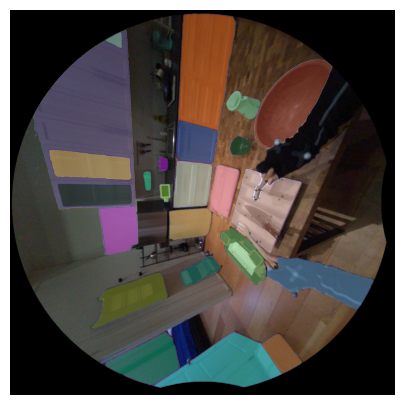

In [14]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
show_anns(results)
plt.axis('off')
plt.show() 

In [ ]:
# Another example with different parameters
# This was take 30x as long to run! (40 seconds vs 1.2 seconds)
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [16]:
masks2 = mask_generator_2.generate(image)

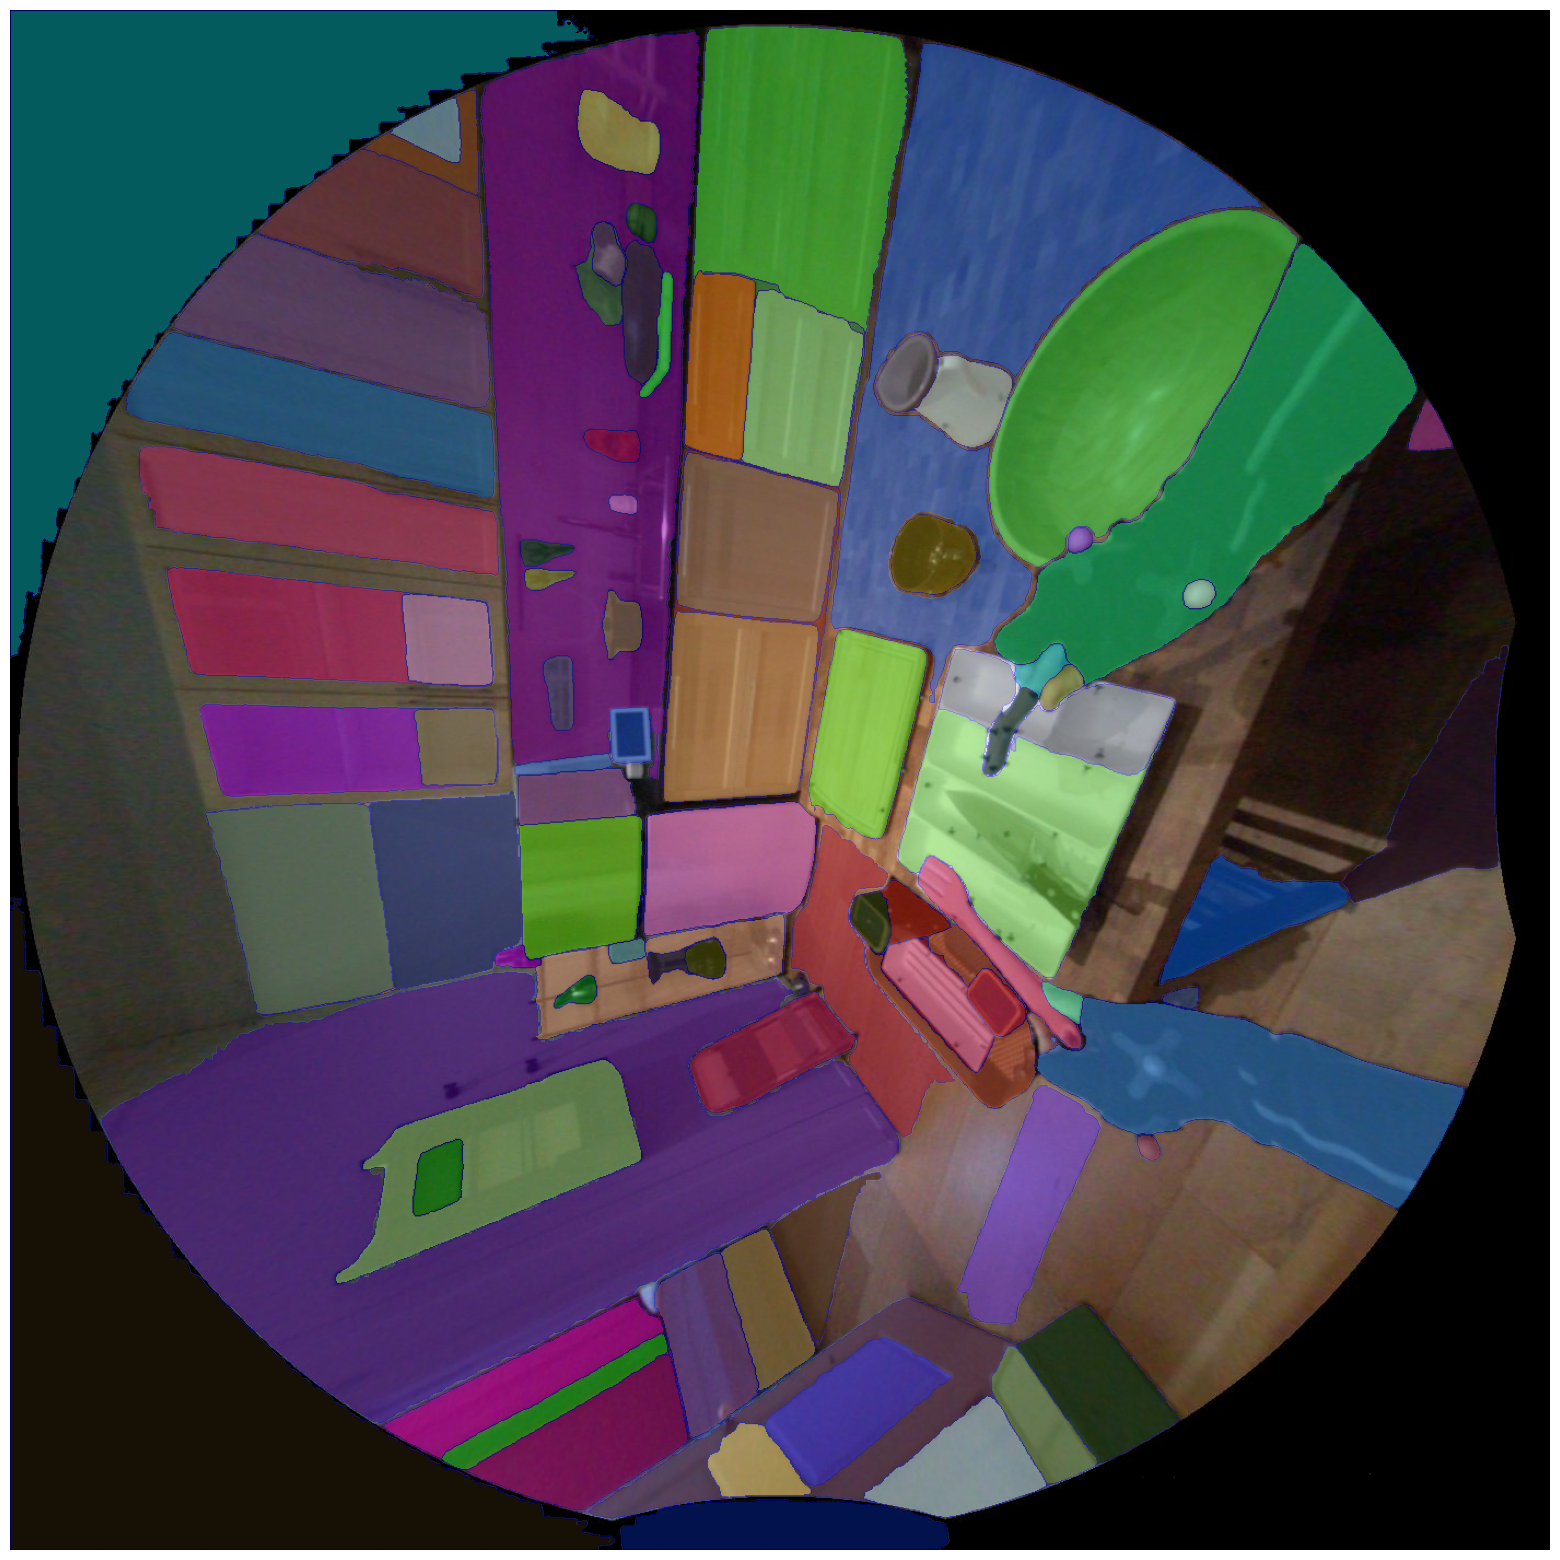

In [18]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [19]:
from sam2.tools.vos_inference import vos_inference

ModuleNotFoundError: No module named 'sam2.tools'

In [6]:
ADT_DIR             = '/home/ubuntu/cs-747-project/adt'
ADT_PROCESSED_DIR   = '/home/ubuntu/cs-747-project/adt_processed_new'
SCENE_NAME          = 'Apartment_release_golden_skeleton_seq100_10s_sample'
# SAM_ENCODER_VERSION = 'vit_h'
# SAM_CHECKPOINT_PATH = 'sam_vit_h_4b8939.pth'

In [ ]:
from typing import Any
import argparse
import json

# define classes (from generate_gsa_results.py)
class Dataset():
    def __init__(self, args) -> None:
        self.input_folder = args.input_folder
        assert self.input_folder.exists(), f"Input folder {self.input_folder} does not exist. "

        self.detection_save_folder = self.input_folder / f"gsa_det_{args.class_set}_{args.sam_variant}"
        self.detection_save_folder.mkdir(exist_ok=True)

        self.vis_save_folder = self.input_folder / f"gsa_vis_{args.class_set}_{args.sam_variant}"
        self.vis_save_folder.mkdir(exist_ok=True)

    def __getitem__(self, index: int) -> Any:
        raise NotImplementedError

    def __len__(self) -> int:
        raise NotImplementedError

class AriaDataset(Dataset):
    def __init__(self, args: argparse.Namespace) -> None:
        super().__init__(args)

        transform_path = self.input_folder / "transforms.json"
        with open(transform_path) as json_file:
            frames = json.loads(json_file.read())["frames"]
        
        # Only keep the RGB images
        self.frames = [f for f in frames if f['camera_name'] == 'rgb']

        self.frames.sort(key=lambda f: f["image_path"])

    def __getitem__(self, index: int) -> Any:
        subpath = self.frames[index]["image_path"]
        image_path = self.input_folder / subpath
        image_filename = subpath[:-4] # remove the .png/.jpg extension

        return image_path, image_filename
    
    def __len__(self) -> int:
        return len(self.frames)

In [ ]:
import numpy as np

# The SAM based on automatic mask generation, without bbox prompting
def get_sam_segmentation_dense(
    variant:str, model: Any, image: np.ndarray
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    The SAM based on automatic mask generation, without bbox prompting
    
    Args:
        model: The mask generator or the YOLO model
        image: )H, W, 3), in RGB color space, in range [0, 255]
        
    Returns:
        mask: (N, H, W)
        xyxy: (N, 4)
        conf: (N,)
    '''
    if variant == "sam":
        results = model.generate(image)
        mask = []
        xyxy = []
        conf = []
        for r in results:
            mask.append(r["segmentation"])
            r_xyxy = r["bbox"].copy()
            # Convert from xyhw format to xyxy format
            r_xyxy[2] += r_xyxy[0]
            r_xyxy[3] += r_xyxy[1]
            xyxy.append(r_xyxy)
            conf.append(r["predicted_iou"])
        mask = np.array(mask)
        xyxy = np.array(xyxy)
        conf = np.array(conf)
        return mask, xyxy, conf
    elif variant == "sam2":
        #TODO
        pass
    elif variant == "fastsam":
        # The arguments are directly copied from the GSA repo
        results = model(
            image,
            imgsz=1024,
            device="cuda",
            retina_masks=True,
            iou=0.9,
            conf=0.4,
            max_det=100,
        )
        raise NotImplementedError
    else:
        raise NotImplementedError

In [5]:
import supervision as sv
from supervision.draw.color import Color, ColorPalette
import dataclasses

def vis_result_fast(
    image: np.ndarray, 
    detections: sv.Detections, 
    classes: list[str], 
    color: Color | ColorPalette = ColorPalette.DEFAULT, 
    instance_random_color: bool = False,
    draw_bbox: bool = True,
) -> np.ndarray:
    '''
    Annotate the image with the detection results. 
    This is fast but of the same resolution of the input image, thus can be blurry. 
    '''
    # annotate image with detections
    box_annotator = sv.BoxAnnotator(
        color = color,
    )
    label_annontator = sv.LabelAnnotator(
        text_scale=0.3,
        text_thickness=1,
        text_padding=2,
    )
    mask_annotator = sv.MaskAnnotator(
        color = color,
        opacity=0.35,
    )
    labels = [
        f"{classes[class_id]} {confidence:0.2f}" 
        for _, _, confidence, class_id, _, _
        in detections]
    
    if instance_random_color:
        # generate random colors for each segmentation
        # First create a shallow copy of the input detections
        detections = dataclasses.replace(detections)
        detections.class_id = np.arange(len(detections))
        
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    
    if draw_bbox:
        annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
        annotated_image = label_annontator.annotate(scene=annotated_image, detections=detections, labels=labels)
    return annotated_image, labels

In [6]:
from pathlib import Path

input_folder = (Path(ADT_PROCESSED_DIR) / SCENE_NAME)
print(f"Input folder: {input_folder}")

Input folder: /home/ubuntu/cs-747-project/adt_processed_new/Apartment_release_golden_skeleton_seq100_10s_sample


In [7]:
classes = ['item']
##### initialize the dataset #####
rotate_back = False
if (input_folder / "global_points.csv.gz").exists():
    print(f"Found global_points.csv.gz file, assuming Aria data set!")
    # dataset = AriaDataset(args)
    dataset = AriaDataset(args=argparse.Namespace(
        input_folder=input_folder,
        class_set='none',
        sam_variant='sam',
    ))
    rotate_back = True
else:
    # Not implemented yet
    raise NotImplementedError("Only Aria data set is supported for now!")

Found global_points.csv.gz file, assuming Aria data set!


In [ ]:
from tqdm import trange
import numpy as np
import imageio
import supervision as sv
import pickle
import gzip
from PIL import Image

stride =1
# TODO experiment with longer side... might be causing aliasing issues?
max_longer_side = 512

annotated_frames = []
global_classes = []

for idx in trange(0, len(dataset), stride):
    # image_path = args.input_folder / frames[idx]["image_path"]
    # image_filename = image_path.name.split('.')[0]
    image_path, image_filename = dataset[idx]

    image_pil = Image.open(image_path)
    # image_pil = image_pil.resize((args.output_width, args.output_height))
    longer_side = min(max(image_pil.size), max_longer_side)
    resize_scale = float(longer_side) / max(image_pil.size)
    image_pil = image_pil.resize(
        (int(image_pil.size[0] * resize_scale), int(image_pil.size[1] * resize_scale))
    )
    # If image is RGBA, drop the alpha channel
    if image_pil.mode == "RGBA":
        image_pil = image_pil.convert("RGB")
    
    if rotate_back:
        image_pil = image_pil.rotate(-90, expand=True)
    image_rgb = np.array(image_pil)
    image_bgr = image_rgb[:, :, ::-1].copy()

    # add classes to global classes
    for c in classes:
        if c not in global_classes:
            global_classes.append(c)
    
    # if args.accumu_classes:
    #     # Use all the classes that have been seen so far
    #     classes = global_classes

    ### Detection and segmentation ###
    # Directly use SAM in dense sampling mode to get segmentation
    mask, xyxy, conf = get_sam_segmentation_dense(
        'sam', mask_generator, image_rgb)

    detections = sv.Detections(
        xyxy=xyxy,
        confidence=conf,
        class_id=np.zeros_like(conf).astype(int),
        mask=mask,
    )

    # Remove the bounding boxes that are too large (they tend to capture the entire image)
    areas = (detections.xyxy[:, 2] - detections.xyxy[:, 0]) * (detections.xyxy[:, 3] - detections.xyxy[:, 1])
    area_ratios = areas / (image_rgb.shape[0] * image_rgb.shape[1])
    valid_idx = area_ratios < 0.6
    detections.xyxy = detections.xyxy[valid_idx]
    detections.confidence = detections.confidence[valid_idx]
    detections.class_id = detections.class_id[valid_idx]
    detections.mask = detections.mask[valid_idx]

    ### Compute CLIP features ###
    # if not args.no_clip:
    #     image_crops, image_feats, text_feats = compute_clip_features(
    #         image_rgb, detections, clip_model, clip_preprocess, clip_tokenizer, classes, args.device)
    # else:
    #     image_crops, image_feats, text_feats = None, None, None
    image_crops, image_feats, text_feats = None, None, None

    ### Save the detection results ###
    detection_save_path = dataset.detection_save_folder / f"{image_filename}.pkl.gz"
    detection_save_path.parent.mkdir(exist_ok=True, parents=True)
    det_results = {
        "image_path": image_path,
        "xyxy": detections.xyxy,
        "confidence": detections.confidence,
        "class_id": detections.class_id,
        "mask": detections.mask,
        "classes": classes,
        "image_crops": image_crops,
        "image_feats": image_feats,
        "text_feats": text_feats,
    }
    with gzip.open(str(detection_save_path), 'wb') as f:
        pickle.dump(det_results, f)

        
    ### Visualize results and save ###
    annotated_image, labels = vis_result_fast(
        image_rgb, detections, classes, 
        # instance_random_color = args.class_set=="none",
        instance_random_color = True,
        # draw_bbox = args.class_set!="none",
        draw_bbox = False,
    )

    vis_save_path = dataset.vis_save_folder / f"{image_filename}.png"
    vis_save_path.parent.mkdir(exist_ok=True, parents=True)
    imageio.imwrite(vis_save_path, annotated_image)
    
    # plt.figure(figsize=(10, 10))
    # plt.imshow(annotated_image)
    # plt.title(f"Frame {idx}")
    # plt.show()
    # cv2.imwrite(vis_save_path, annotated_image)
    annotated_frames.append(annotated_image)

# Save the annotated frames as a video
annotated_frames = np.stack(annotated_frames, axis=0)

imageio.mimwrite(
    input_folder / f"gsa_vis_none_sam2.mp4",
    annotated_frames,
    fps=20,
)

  0%|          | 0/267 [00:00<?, ?it/s]

  3%|▎         | 9/267 [00:31<14:49,  3.45s/it]


KeyboardInterrupt: 